# PLASMA -- PREDICT Mappings Demo

In this notebook we're investigating mappings of primitive devices.

Modeling and Approximation the Operating Point Data of Primitive Devices.

+ Requirements:
    - PREDICT data as hdf5, should be stored like so
    
        ```python
            import hdf5 as h5
            with h5_file h5.File("/path/to/{tech}-{device-type}.h5", "w"):
                for col in data:
                    h5_file[col] = data[col].to_numpy()
        ```

        where `data` is the PREDICT dataframe in python. (assuming pandas is
        used).

    - Dependencies installed:

        ```bash
        $ pip install -r ./requirements.text
        ```

## Setup

In [1]:
import os, datetime, time, sys
from fastprogress.fastprogress import master_bar, progress_bar
from functools import partial
from expression import compose, pipe
import h5py as h5
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import joblib as jl
import torch as pt
from torch.utils.data.dataset import TensorDataset
from torch.utils.data.dataloader import DataLoader
from sklearn.preprocessing import MinMaxScaler, minmax_scale
from sklearn.model_selection._split import train_test_split

In [2]:
rng_seed = 666
eng = mpl.ticker.EngFormatter()
sns.set_theme(style="darkgrid")

In [3]:
device_type = "nmos"
tech        = "gpdk180"
data_path   = f"../data/{tech}-{device_type}.h5"
time_stamp  = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_dir   = f"./models/{time_stamp}-{device_type}-{tech}"

In [4]:
os.makedirs(model_dir, exist_ok = True)

## Data Handling

Load HDF database containing X-FAB XH035 3V3 NMOS characterization data.

In [5]:
with h5.File(data_path, 'r') as db:
    col_names   = list(db.keys())
    data_matrix = np.transpose(np.array([db[c] for c in col_names]))
    data_raw    = pd.DataFrame(data_matrix, columns=col_names).dropna()

Specify inputs, outputs and which columns should be normalized and/or transformed.

In [6]:
params_x = ["Vds", "Vgs", "Vbs", "W", "L"]
params_y = ["vth","vdsat","ron","gm","gmbs","gds","betaeff","id","vearly","pwr","fug"]
         # ,"self_gain","rout","gmoverid","cgs","cgd","cdb"

normed_y = ["ron","gm","gmbs","gds","betaeff","id","pwr"]
trafo_y  = ["fug", "betaeff", "pwr", "gmbs", "gds", "gm", "vdsat", "ron", "id","vearly"]

Normalize over 
$W$ 
and remove `NaN`s and `+/-Inf`s.

In [7]:
sat_samples = 200000 # data_raw.shape[0]
oth_samples = int(sat_samples/3)

data_sat    = (data_raw.Vgs > data_raw.vth) & (data_raw.Vds > (data_raw.Vgs - data_raw.vth))

data_sample = pd.concat([ data_raw[ data_sat].sample(sat_samples, replace = False)
                        , data_raw[~data_sat].sample(oth_samples, replace = False)])

In [8]:
for py in normed_y:
    data_sample[py] = data_sample[py] / data_sample["W"]
    
data_sample =  data_sample.replace([np.inf, -np.inf], np.nan).dropna()

Draw samples from the dataset, with emphasis on saturation region, where $V_{gs} > V_{th}$ and $V_{ds} > V_{gs} - V_{th}$.

### Distribution Analysis

Investigate distribution of data and how this may relate to training behavior. Begin by splitting data into inputs and outputs.

In [9]:
data_x = data_sample[params_x]
data_y = data_sample[params_y]

Scale such that $$x,y \in [0;1]$$

In [10]:
data_norm_x = pd.DataFrame(minmax_scale(data_x.values), columns = params_x)
data_norm_y = pd.DataFrame(minmax_scale(data_y.values), columns = params_y)

Text(0.5, 1.0, 'Scaled Y Parameters')

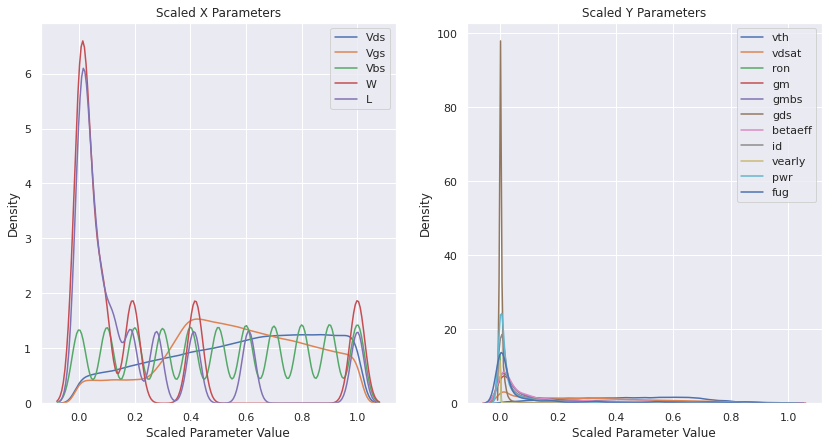

In [11]:
fig, (ax1, ax2) = plt.subplots(figsize=(14,7), nrows=1, ncols=2)

for c in data_norm_x.columns.values:
    sns.kdeplot(data_norm_x[c], ax=ax1, label=c)

for c in data_norm_y.columns.values:
    sns.kdeplot(data_norm_y[c], ax=ax2, label=c)

ax1.set_xlabel("Scaled Parameter Value")
ax1.set_ylabel("Density")
ax1.legend()
ax1.set_title("Scaled X Parameters")
ax2.set_xlabel("Scaled Parameter Value")
ax2.set_ylabel("Density")
ax2.legend()
ax2.set_title("Scaled Y Parameters")

The un-transformed output parameters (Scaled Y Parameters) show a _terrible_ distribution. Any NN may have trouble converging. Therefore certain $y$ parameters are transformed such that

$$ \bar{y} = \log_{10} |y_{t}| $$

for $t \in \mathtt{trafo_y}$.

In [12]:
data_trafo        = data_sample[(params_x + params_y)].copy()

for t in trafo_y:
    data_trafo[t] = np.log10(np.abs(data_trafo[t].values), where=(data_trafo[t].values != 0))
    
data_scale        = pd.DataFrame(minmax_scale(data_trafo.values), columns=(params_x + params_y))

data_scale_x      = data_scale[params_x]
data_scale_y      = data_scale[params_y]

Text(0.5, 1.0, 'Transformed Y Parameters')

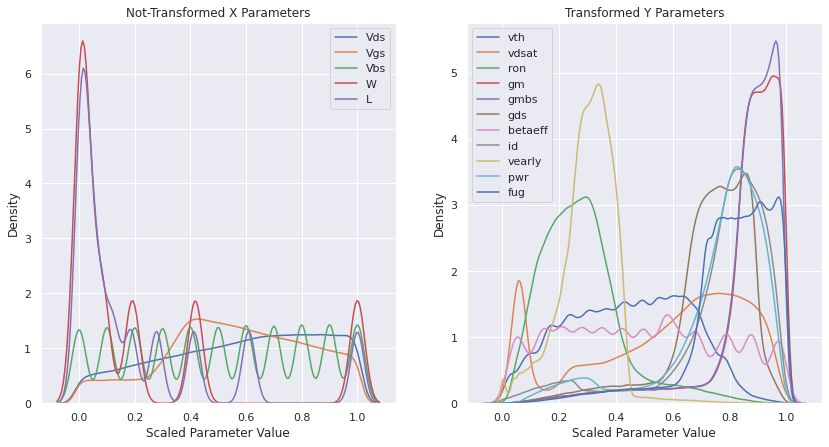

In [13]:
fig, (ax1, ax2) = plt.subplots(figsize=(14,7), nrows=1, ncols=2)

for c in data_scale_x.columns.values:
    sns.kdeplot(data_scale_x[c], ax = ax1, label = c)

for c in data_scale_y.columns.values:
    sns.kdeplot(data_scale_y[c], ax = ax2, label = c)

ax1.set_xlabel("Scaled Parameter Value")
ax1.set_ylabel("Density")
ax1.legend()
ax1.set_title("Not-Transformed X Parameters")
ax2.set_xlabel("Scaled Parameter Value")
ax2.set_ylabel("Density")
ax2.legend()
ax2.set_title("Transformed Y Parameters")

This yields a _much improved_ distribution of output parameters for training purpouses. The scaleres are stored for reconstruction of results later.

In [14]:
scale_x = MinMaxScaler()
scale_y = MinMaxScaler()

data_scale_x = scale_x.fit_transform(data_trafo[params_x].values)
data_scale_y = scale_y.fit_transform(data_trafo[params_y].values)

jl.dump(scale_x, f"{model_dir}/scale.X");
jl.dump(scale_y, f"{model_dir}/scale.Y");

## Training Data Setup

Here the data is converted for use with pytorch.

In [15]:
test_split  = 0.2
batch_size  = 25
num_epochs  = 42
epoch_bar   = master_bar(range(1, num_epochs + 1))
compute_dev = "cuda" if pt.cuda.is_available() else "cpu"

In [16]:
train_x, valid_x, train_y, valid_y = train_test_split( data_scale_x, data_scale_y
                                                     , test_size = test_split
                                                     , shuffle = True
                                                     , random_state = rng_seed
                                                     , )

In [17]:
train_loader = DataLoader( TensorDataset( pt.Tensor(train_x)
                                        , pt.Tensor(train_y))
                         , batch_size, pin_memory = True)
valid_loader = DataLoader( TensorDataset( pt.Tensor(valid_x)
                                        , pt.Tensor(valid_y))
                         , batch_size, pin_memory = True)

## The Neural Network

In [18]:
def plasma_net(num_x: int, num_y: int, comp_dev: str) -> pt.nn.Sequential:
    return pt.nn.Sequential( pt.nn.Linear(num_x, 32) , pt.nn.ReLU()
                           , pt.nn.Linear(32, 128)   , pt.nn.ReLU()
                           , pt.nn.Linear(128, 512)  , pt.nn.ReLU()
                           , pt.nn.Linear(512, 128)  , pt.nn.ReLU()
                           , pt.nn.Linear(128, 64)   , pt.nn.ReLU()
                           , pt.nn.Linear(64, 32)    , pt.nn.ReLU() 
                           , pt.nn.Linear(32, num_y) 
                           , ).to(comp_dev)

In [19]:
num_x  = len(params_x)
num_y  = len(params_y)

net = plasma_net(num_x, num_y, compute_dev)

Define Loss functions and optimization algorithm.

In [20]:
loss_mse = pt.nn.MSELoss()
loss_mae = pt.nn.L1Loss()

In [21]:
λ = 0.001
β = (0.9, 0.999)
optimizer = pt.optim.Adam(net.parameters(), lr = λ, betas = β)

In [22]:
def forward_train(X_train, Y_train):
    optimizer.zero_grad()
    out_train = net(X_train)
    mse = loss_mse(out_train, Y_train)
    mse.backward()
    optimizer.step()
    epoch_bar.child.comment = f"Train Batch MSE: {mse:.4}"
    return mse.item()

In [23]:
def forward_valid(X_valid, Y_valid):
    out_valid = net(X_valid)
    mae = loss_mae(out_valid, Y_valid)
    epoch_bar.child.comment = f"Valid Batch MAE: {mae:.4}"
    return mae.item()

In [24]:
def plot_loss(epoch, epochs, bar, train_loss, valid_loss):
    x = range(1, epoch + 1)
    y = np.concatenate((train_loss, valid_loss))
    
    graphs = [[x,train_loss], [x,valid_loss]]
    
    x_margin = 0.2
    y_margin = 0.2
    
    max_y = np.max(y)
    min_y = np.min(y)
    
    x_bounds = [1 - x_margin, epochs + x_margin]
    y_bounds = [ min_y - (y_margin * min_y)
               , max_y + (y_margin * max_y) ]

    bar.update_graph(graphs, x_bounds, y_bounds)

## Training

Go through training loop for `num_epochs` iterations.

In [25]:
train_losses, valid_losses = [], []

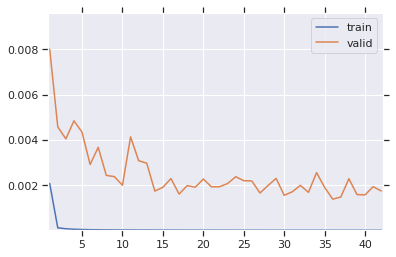

In [26]:
for epoch in epoch_bar:
    net.train()
    train_batch_losses = np.array([ forward_train(x.to(compute_dev), y.to(compute_dev)) 
                                    for (x, y) in progress_bar(train_loader, parent = epoch_bar)])
    train_loss = train_batch_losses.mean()
    train_losses.append(train_loss)
    
    with pt.no_grad():
        net.eval()
        valid_batch_losses = np.array([ forward_valid(x.to(compute_dev), y.to(compute_dev)) 
                                        for (x, y) in progress_bar(valid_loader, parent = epoch_bar)])
        valid_loss = valid_batch_losses.mean()
        valid_losses.append(valid_loss)
        
    if len(valid_losses) > 1 and valid_losses[-2] > valid_loss:
        pt.save(net.state_dict(), f"{model_dir}/model.ckpt")
        
    epoch_bar.main_bar.comment = f"Train MSE: {train_loss:.4}, Valid MAE: {valid_loss:.4}"
    plot_loss(epoch, num_epochs, epoch_bar, train_losses, valid_losses)
    
epoch_bar.write(f"Finished {num_epochs} Epochs, best model checkpoint at {model_dir}/model.ckpt.")

Save the best model as TorchScript.

In [27]:
model = plasma_net(len(params_x), len(params_y), compute_dev)

model.load_state_dict(pt.load(f"{model_dir}/model.ckpt"))

model.cpu().eval()

pt.jit.trace(model, example_inputs = pt.rand(1, len(params_x))).save(f"{model_dir}/model.pt")

## Evaluation

Reload the trained model for a fresh start, as you would in production.

In [28]:
class PlasmaModel:
    def __init__( self, path: str
                , params_x: [str], params_y: [str]
                , trafo_x: [str],  trafo_y: [str] 
                , norm_y: [str] ):
        self.params_x = params_x
        self.params_y = params_y
        self.norm_y   = norm_y
        
        self.mask_x   = np.array([int(px in trafo_x) for px in self.params_x])
        self.mask_y   = np.array([int(py in trafo_y) for py in self.params_y])
        
        self.scaler_x = jl.load(f"{path}/scale.X")
        self.scaler_y = jl.load(f"{path}/scale.Y")
        self.scale_x  = lambda X: self.scaler_x.transform(X)
        self.scale_y  = lambda Y: self.scaler_y.inverse_transform(Y)
        
        self.trafo_x  = lambda X: (np.log10(np.abs(X), where = (np.abs(X) > 0)) * self.mask_x) + (X * (1 - self.mask_x))
        self.trafo_y  = lambda Y: (np.power(10, Y) * self.mask_y) + (Y * (1 - self.mask_y))
        
        self.model    = pt.jit.load(f"{path}/model.pt").cpu().eval()
    
    def _predict(self, X: np.array) -> np.array:
        with pt.no_grad():
            return pipe( X
                       , self.trafo_x
                       , self.scale_x
                       , np.float32
                       , pt.from_numpy
                       , self.model
                       , pt.Tensor.numpy
                       , self.scale_y
                       , self.trafo_y
                       , )
        
    def predict(self, X: pd.DataFrame) -> pd.DataFrame:
        Y = pd.DataFrame( self._predict(X[self.params_x].values)
                        , columns = self.params_y )
        Y[self.norm_y] = Y[self.norm_y].multiply(X.reset_index(drop = True)["W"], axis = "index")
        return Y

In [29]:
mdl = PlasmaModel(model_dir, params_x, params_y, [], trafo_y, normed_y)

### Transfer- and Output-Characteristic

Plot the Transfer-Characteristic $I_{d}$ vs. $V_{gs}$ and the Output-Characteristic $I_{d}$ vs $V_{ds}$ for a random $W$ and $L$ from the dataset.

In [30]:
W = np.random.choice(data_raw.W)
L = np.random.choice(data_raw.L)

traces = data_raw[(data_raw.W == W) & (data_raw.L == L) & (data_raw.Vbs == 0.0)][params_x + params_y].copy().reset_index(drop=True)
traces["Vgs"] = round(traces.Vgs, ndigits = 2)
traces["Vds"] = round(traces.Vds, ndigits = 2)
traces["Vbs"] = round(traces.Vbs, ndigits = 2)

tru_x = traces[params_x]
tru_y = traces[params_y]

Make a prediction.

In [31]:
prd_y = mdl.predict(tru_x)

Text(0.5, 1.0, 'Output Characteristic')

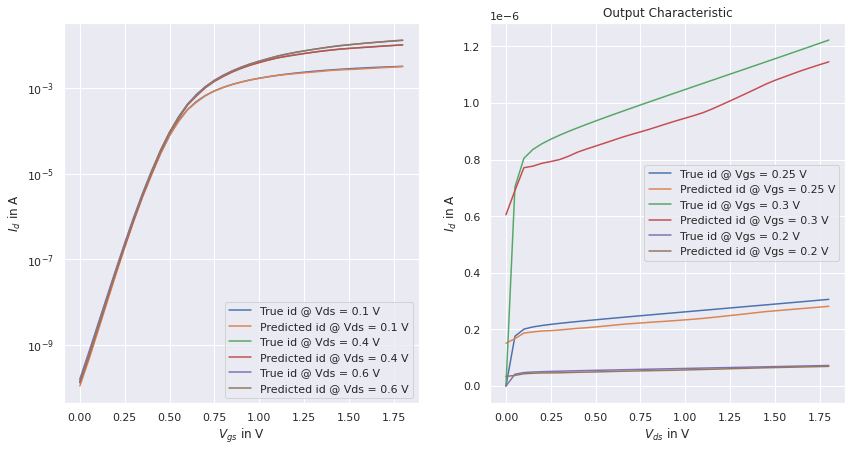

In [32]:
fig, (ax1, ax2) = plt.subplots(figsize = (14, 7), nrows=1, ncols = 2)

for v in np.random.choice(traces.Vds.unique(), 3, replace = False):
    tru = tru_x[tru_x.Vds == v]
    ty = tru_y.loc[tru.index]["id"]
    py = prd_y.loc[tru.index]["id"]
    ax1.plot(tru.Vgs, np.abs(ty), label = f"True id @ Vds = {v} V")
    ax1.plot(tru.Vgs, np.abs(py), label = f"Predicted id @ Vds = {v} V")
ax1.grid("on")
ax1.set_xlabel("$V_{gs}$ in V")
ax1.set_ylabel("$I_{d}$ in A")
ax1.set_yscale("log")
ax1.legend()
ax2.set_title("Transfer Characteristic")

for v in np.random.choice(traces.Vgs.unique(), 3, replace = False):
    tru = tru_x[tru_x.Vgs == v]
    ty = tru_y.loc[tru.index]["id"]
    py = prd_y.loc[tru.index]["id"]
    ax2.plot(tru.Vds, np.abs(ty), label = f"True id @ Vgs = {v} V")
    ax2.plot(tru.Vds, np.abs(py), label = f"Predicted id @ Vgs = {v} V")
ax2.grid("on")
ax2.set_xlabel("$V_{ds}$ in V")
ax2.set_ylabel("$I_{d}$ in A")
ax2.legend()
ax2.set_title("Output Characteristic")

### Prediction Loss

Normalized prediction loss 
$$
p_{\Delta} = \frac{|t - p|}{t}
$$

where $t$ is the ground truth and $p$ the prediction.

In [33]:
prd_Δ = ( abs(prd_y - tru_y) / tru_y).replace( [np.inf, -np.inf]
                                             , np.nan ).dropna().reset_index(drop=True)

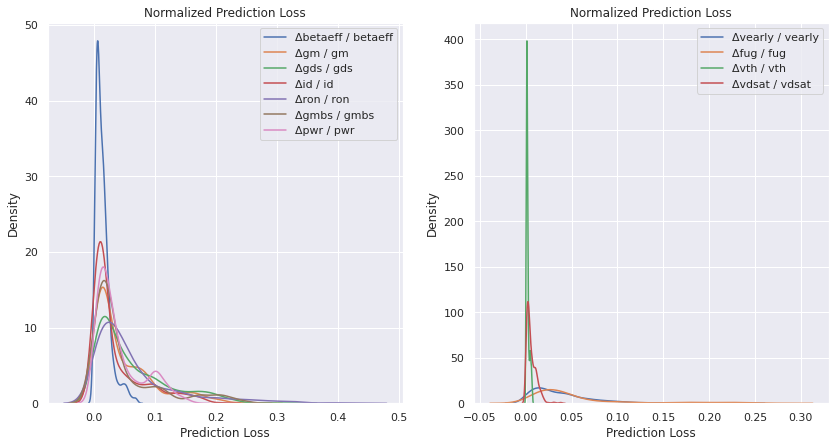

In [34]:
fig, (ax1, ax2) = plt.subplots(figsize=(14,7), nrows=1, ncols=2)
all_y = set(params_y)
nrm_y = set(normed_y)
rst_y = all_y ^ nrm_y
for c in nrm_y:
    sns.kdeplot(prd_Δ[c], ax = ax1, label = f"Δ{c} / {c}")
ax1.set_xlabel("Prediction Loss")
ax1.set_ylabel("Density")
ax1.legend()
ax1.set_title("Normalized Prediction Loss")
for c in rst_y:
    sns.kdeplot(prd_Δ[c], ax = ax2, label = f"Δ{c} / {c}")
ax2.set_xlabel("Prediction Loss")
ax2.set_ylabel("Density")
ax2.legend()
ax2.set_title("Normalized Prediction Loss")
plt.show()

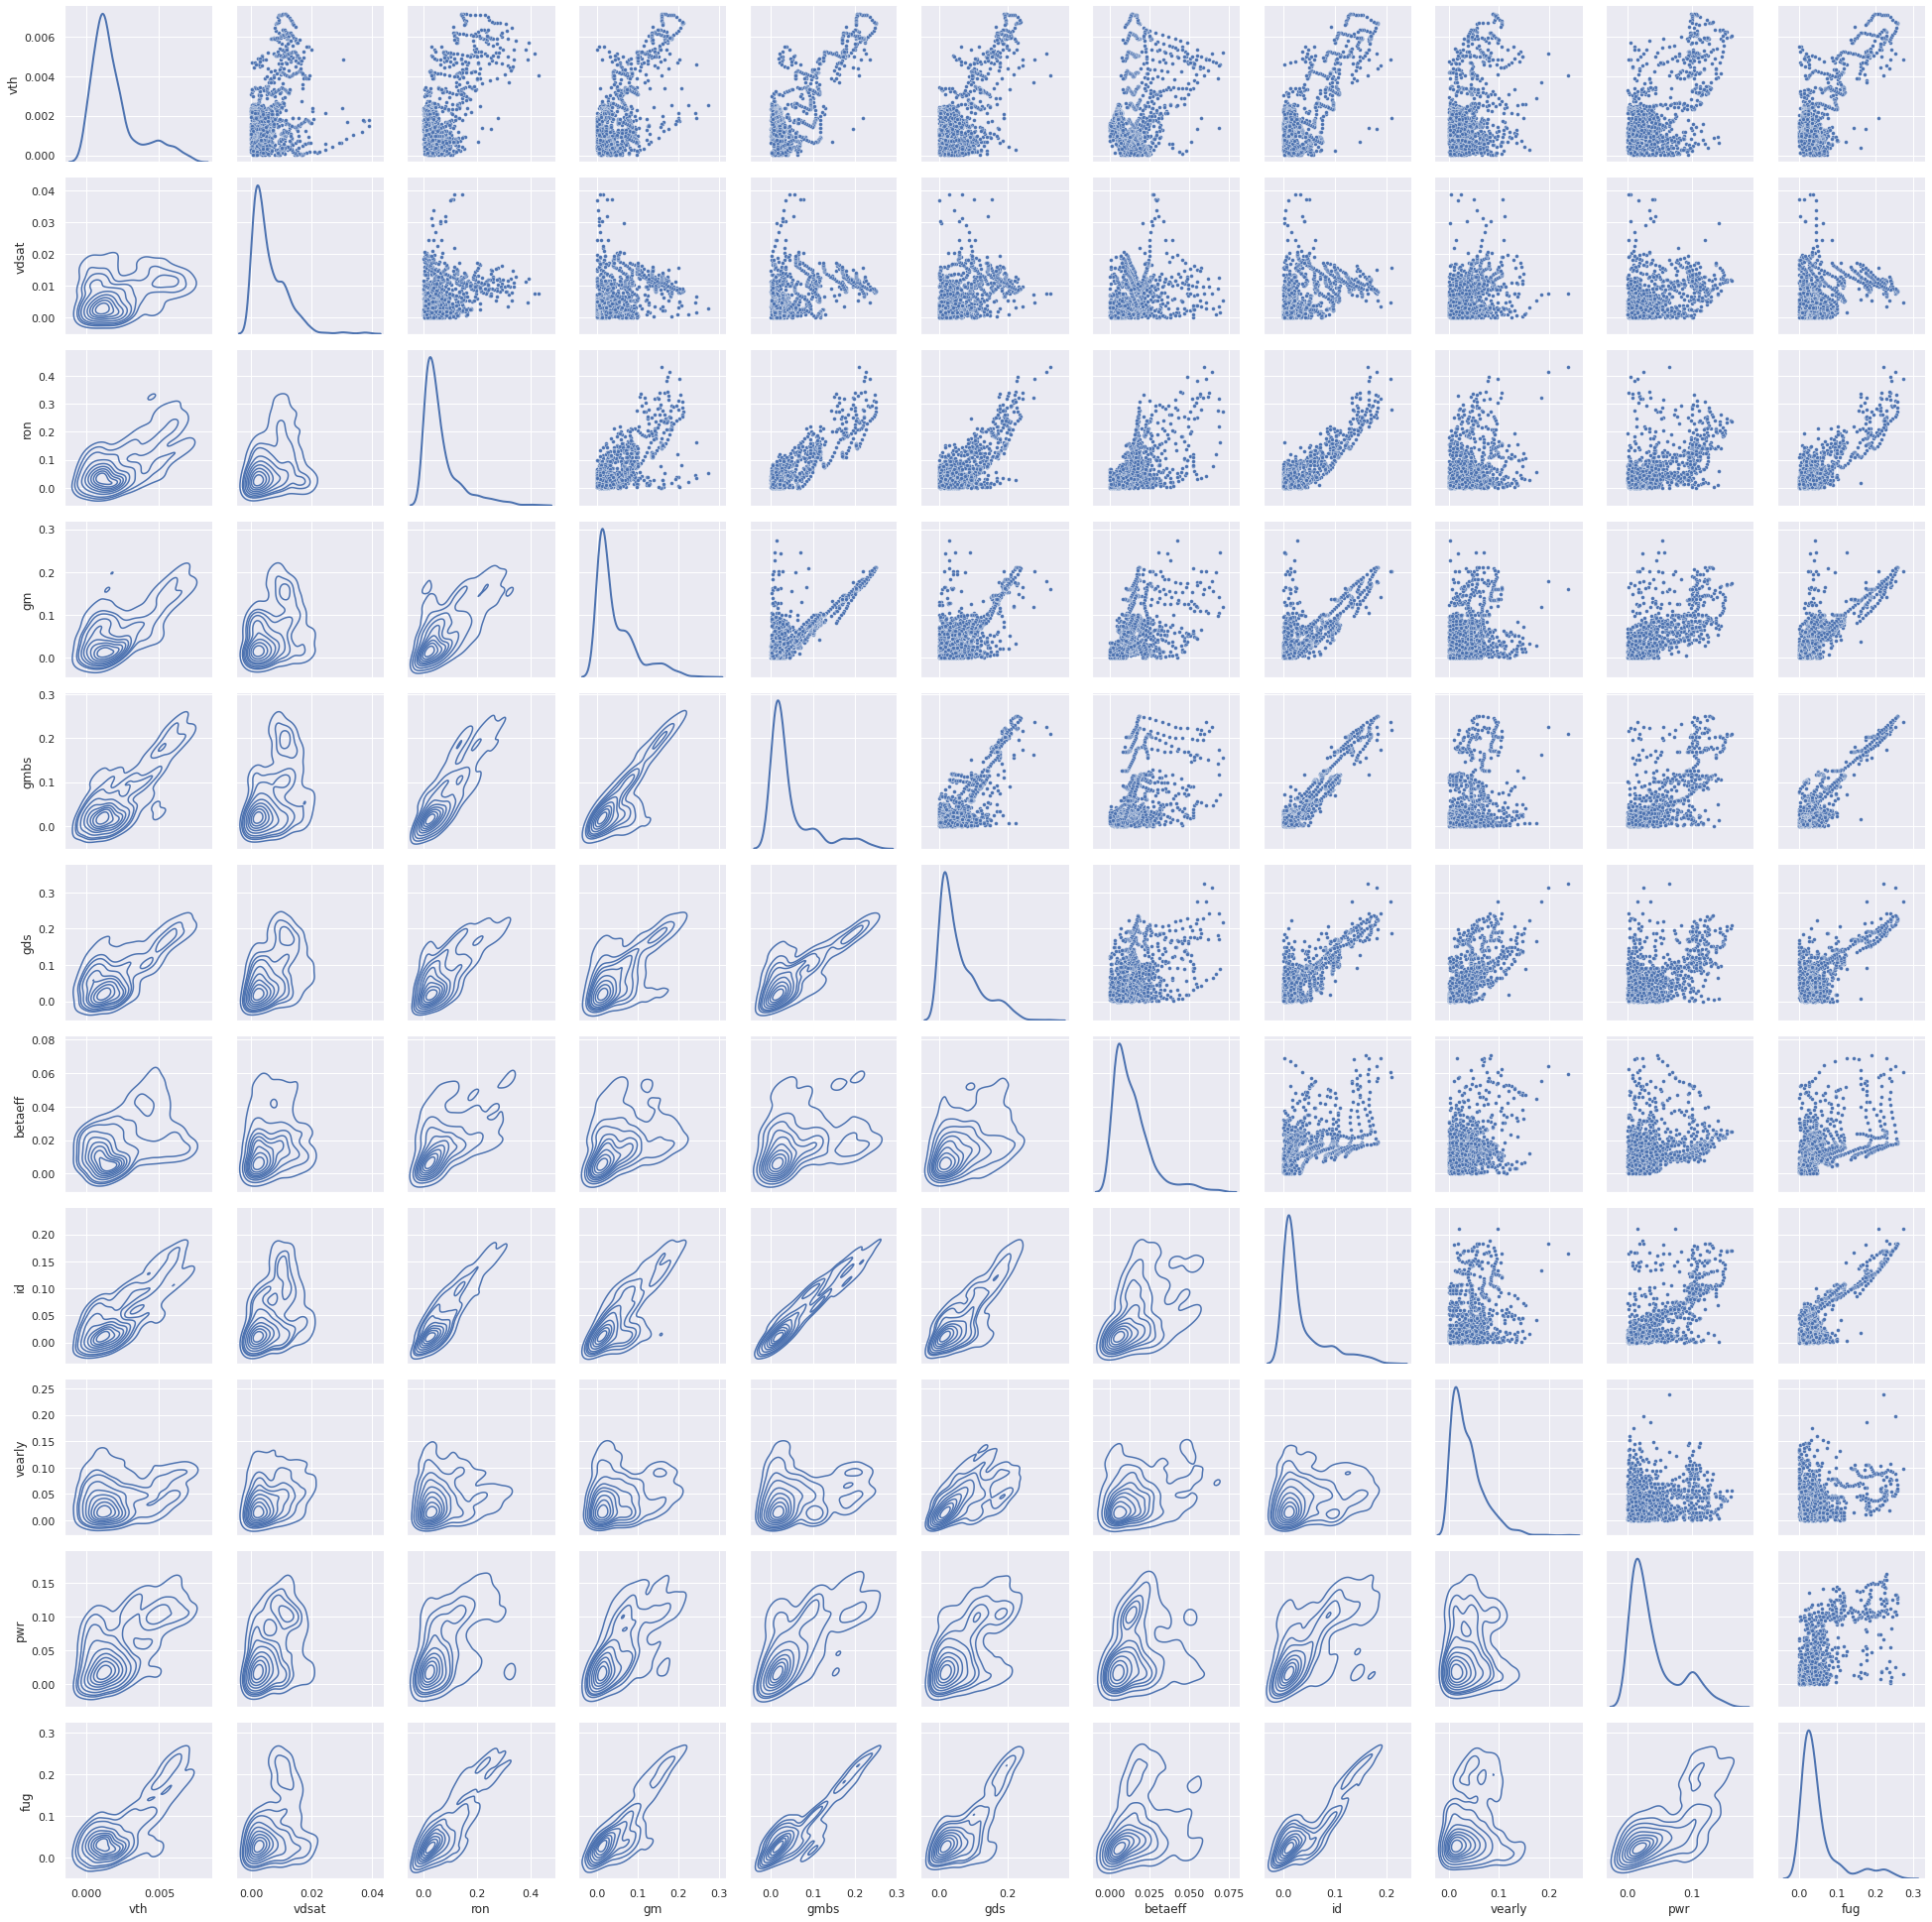

In [35]:
g = sns.PairGrid(prd_Δ, diag_sharey = False)
g.map_upper(sns.scatterplot, s = 15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw = 2)